In [1]:
# Setup and imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path().absolute()
sys.path.insert(0, str(project_root))

import numpy as np
from datetime import datetime, timedelta

In [2]:
# Data preparation: Load real historical data with technical indicators and news documents
# NOTE: This cell might take 2-3 minutes to run
from rl_utils.data import prepare_data_features

ticker = 'AAPL'
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*1.5)).strftime('%Y-%m-%d')  # 1.8 years of data
timeframe = '1D'

# Fetch real data with indicators, news embeddings, and news documents
data, news_documents = prepare_data_features(ticker, start_date, end_date, timeframe)

data.head()

,symbol,Open,High,Low,Close,Volume,EMA_FAST,EMA_MEDIUM,EMA_SLOW,SMA_SHORT,...,CCI,ULTOSC,WILLR,RANGE_HIGH,RANGE_LOW,PULLBACK_REF_HIGH,PULLBACK_REF_LOW,return_1d,return_3d,return_5d
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-16 04:00:00+00:00,AAPL,216.54,217.22,213.92,216.32,59357427.0,221.538768,222.292525,221.449797,223.505333,...,-181.458644,54.490514,-87.368421,229.79,216.32,222.77,216.32,-0.027775,-0.028474,-0.020778
2024-09-17 04:00:00+00:00,AAPL,215.75,216.90,214.50,216.79,45519339.0,220.675356,221.792296,221.267059,222.812667,...,-148.904207,60.058614,-84.894737,229.79,216.32,222.77,216.32,0.002173,-0.026844,-0.015083
2024-09-18 04:00:00+00:00,AAPL,217.55,222.71,217.54,220.69,59894928.0,220.678018,221.692087,221.244430,222.323333,...,-58.806988,58.779150,-64.368421,229.79,216.32,222.77,216.32,0.017990,-0.008135,-0.008848
2024-09-19 04:00:00+00:00,AAPL,224.99,229.82,224.63,228.87,66781315.0,222.167470,222.344625,221.543472,222.482000,...,86.200386,63.512492,-9.283981,229.79,216.32,228.87,216.32,0.037066,0.058016,0.027383
2024-09-20 04:00:00+00:00,AAPL,229.97,233.09,227.62,228.20,318679888.0,223.264293,222.876932,221.804512,222.376000,...,111.272465,55.652136,-25.508607,229.00,216.32,228.87,216.32,-0.002927,0.052632,0.025618


In [3]:
# Configure rolling window parameters
TRAIN_WINDOW = 200        # Days for training
TEST_WINDOW = 30          # Days for testing
FORECASTER_LOOKBACK = 60  # LSTM input window
FORECAST_HORIZON = 4      # Days ahead to forecast
ALGO = 'SAC'            # Algorithm to use: 'SAC' or 'PPO'

# Calculate rolling windows
total_days = len(data)
num_windows = max(1, (total_days - TRAIN_WINDOW) // TEST_WINDOW)

print(f"Total data: {total_days} days")
print(f"Train window: {TRAIN_WINDOW} days")
print(f"Test window: {TEST_WINDOW} days")
print(f"Forecaster lookback: {FORECASTER_LOOKBACK} days")
print(f"Forecast horizon: {FORECAST_HORIZON} days")
print(f"Number of rolling windows: {num_windows}")

# Create window definitions
windows = []
for i in range(num_windows):
    train_start = i * TEST_WINDOW
    train_end = train_start + TRAIN_WINDOW
    test_start = train_end
    test_end = min(test_start + TEST_WINDOW, total_days)
    
    # Need at least 10 days for testing
    if test_end - test_start < 10:
        break
    
    windows.append({
        'window_id': i,
        'train_range': (train_start, train_end),
        'test_range': (test_start, test_end)
    })

Total data: 313 days
Train window: 200 days
Test window: 30 days
Forecaster lookback: 60 days
Forecast horizon: 4 days
Number of rolling windows: 3


In [4]:
# Initialize shared models for incremental learning across windows
global_forecaster = None
global_interpreter = None

# Select feature columns (exclude target and non-numeric)
feature_columns = [c for c in data.columns 
                   if c not in ['Close'] and data[c].dtype in [np.float64, np.float32, np.int64]]

print(f"Using {len(feature_columns)} features for forecaster:")
print(f"  {feature_columns}")

# Storage for results across windows
all_results = []

Using 39 features for forecaster:
  ['Open', 'High', 'Low', 'Volume', 'EMA_FAST', 'EMA_MEDIUM', 'EMA_SLOW', 'SMA_SHORT', 'SMA_MEDIUM', 'SMA_LONG', 'H-L', 'H-PC', 'L-PC', 'TR', 'ATR', '+DM', '-DM', 'TR_DMI', '+DM_DMI', '-DM_DMI', '+DI', '-DI', 'Vol_MA', 'RVOL', 'VOL_EXPAND', 'OBV', 'OBV_MA', 'ROC', 'MFI', 'CCI', 'ULTOSC', 'WILLR', 'RANGE_HIGH', 'RANGE_LOW', 'PULLBACK_REF_HIGH', 'PULLBACK_REF_LOW', 'return_1d', 'return_3d', 'return_5d']


In [5]:
# Adaptive rolling window training loop using CleanRL scripts
import torch
import pandas as pd
import gymnasium as gym
from gymnasium.envs.registration import register
import contextlib
import os
from typing import Dict, Any, List

# Import CleanRL training functions
import CleanRL_API.sac_continuous_action
from CleanRL_API.sac_continuous_action import train as train_sac, Args as SACArgs

import CleanRL_API.ppo_continuous_action
from CleanRL_API.ppo_continuous_action import train as train_ppo, Args as PPOArgs

# Import Environment components
from rl_env import (
    SignalTesterEnv,
    UncertaintyForecaster,
    NewsInterpreter,
    train_uncertainty_forecaster
)

def calculate_metrics(returns, benchmark_returns):
    """Calculate performance metrics."""
    # Convert to numpy arrays
    r = np.array(returns)
    b = np.array(benchmark_returns)
    
    # Cumulative Return
    cum_ret = np.prod(1 + r) - 1
    bench_cum_ret = np.prod(1 + b) - 1
    
    # Win Rate
    win_rate = np.mean(r > 0)
    
    # Annualized Sharpe Ratio (assume 252 trading days)
    if np.std(r) > 1e-6:
        sharpe = np.mean(r) / np.std(r) * np.sqrt(252)
    else:
        sharpe = 0.0
        
    # Annualized Sortino Ratio
    downside_r = r[r < 0]
    if len(downside_r) > 0 and np.std(downside_r) > 1e-6:
        sortino = np.mean(r) / np.std(downside_r) * np.sqrt(252)
    else:
        sortino = 0.0
        
    # Jensen's Alpha (assume Rf=0)
    # Beta = Cov(r, b) / Var(b)
    if np.var(b) > 1e-6:
        covariance = np.cov(r, b)[0, 1]
        beta = covariance / np.var(b)
        alpha = np.mean(r) - beta * np.mean(b)
        # Annualize Alpha
        alpha = alpha * 252
    else:
        alpha = 0.0
        
    return {
        'Return': cum_ret,
        'Benchmark Return': bench_cum_ret,
        'Win Rate': win_rate,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Jensen Alpha': alpha
    }

def generate_env_inputs(
    data_slice: pd.DataFrame, 
    full_data: pd.DataFrame, 
    start_idx: int, 
    forecaster: UncertaintyForecaster, 
    interpreter: NewsInterpreter,
    lookback: int,
    news_docs: dict,
    feature_cols: list
) -> tuple[Dict, Dict]:
    """
    Pre-compute forecasts and news contexts for the environment.
    """
    uncertainty_forecasts = {}
    news_contexts = {}
    
    device = next(forecaster.parameters()).device
    
    print(f"Generating inputs for {len(data_slice)} steps...")
    
    for i in range(len(data_slice)):
        global_idx = start_idx + i
        
        # 1. Generate Forecast
        if global_idx < lookback:
            pass 
        else:
            # Get lookback window
            window_df = full_data.iloc[global_idx - lookback : global_idx]
            x_np = window_df[feature_cols].values
            x_tensor = torch.FloatTensor(x_np).unsqueeze(0).to(device) # (1, lookback, features)
            
            # Generate forecast (mocked/untrained if forecaster is new)
            forecast = forecaster.predict_with_uncertainty(x_tensor, n_samples=20)
            uncertainty_forecasts[i] = forecast
            
        # 2. Generate News Context
        doc = news_docs.get(global_idx, "")
        if doc:
            context = interpreter.get_full_context(doc)
            news_contexts[i] = context
            
    return uncertainty_forecasts, news_contexts

# Main Loop
results = []
evaluation_results = []
daily_returns_history = [] # Store daily returns for plotting
log_dir = "training_logs"
os.makedirs(log_dir, exist_ok=True)
print(f"Training logs will be saved to: {os.path.abspath(log_dir)}")

# loop over windows
for window in windows: 
    window_id = window['window_id']
    train_range = window['train_range']
    test_range = window['test_range']
    
    print(f"\n=== Processing Window {window_id} ===")
    print(f"Train: {train_range}, Test: {test_range}")
    
    # 1. Prepare Data Slices
    train_data = data.iloc[train_range[0]:train_range[1]].reset_index(drop=True)
    test_data = data.iloc[test_range[0]:test_range[1]].reset_index(drop=True)
    
    # 2. Update/Train Forecaster (Mocked/Simplified)
    if global_forecaster is None:
        print("Initializing Forecaster...")
        input_dim = len(feature_columns)
        global_forecaster = UncertaintyForecaster(
            input_dim=input_dim,
            hidden_dim=64,
            forecast_horizon=FORECAST_HORIZON
        )
        # Move to device if available
        # global_forecaster.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 3. Update/Fit Interpreter
    if global_interpreter is None:
        print("Initializing Interpreter...")
        global_interpreter = NewsInterpreter()
        # Fit on initial training data news
        train_docs = [news_documents.get(i, "") for i in range(train_range[0], train_range[1]) if news_documents.get(i)]
        if train_docs:
            global_interpreter.fit(train_docs)
        else:
            print("Warning: No news documents for fitting!")
            
    # 4. Generate Environment Inputs
    print("Pre-computing environment inputs...")
    train_forecasts, train_contexts = generate_env_inputs(
        train_data, data, train_range[0], 
        global_forecaster, global_interpreter, 
        FORECASTER_LOOKBACK, news_documents, feature_columns
    )
    
    # 5. Register Environment for this window
    env_id = f"SignalTester-w{window_id}-v0"
    
    # Check if already registered and remove if so
    if env_id in gym.envs.registry:
        del gym.envs.registry[env_id]
        
    register(
        id=env_id,
        entry_point="rl_env:SignalTesterEnv",
        kwargs={
            "data": train_data,
            "uncertainty_forecasts": train_forecasts,
            "news_contexts": train_contexts,
            "episode_length": 252, # Approx 1 trading year
        }
    )
    
    # 6. Run CleanRL Training
    log_file = os.path.join(log_dir, f"{ALGO.lower()}_{env_id}.log")
    print(f"Starting {ALGO} training on {env_id}...")
    print(f"  > Logs redirected to: {log_file}")
    
    # Define Args based on ALGO
    if ALGO == 'SAC':
        args = SACArgs(
            env_id=env_id,
            total_timesteps=5000, 
            policy_lr=3e-4,
            q_lr=1e-3,
            buffer_size=10000,
            gamma=0.99,
            tau=0.005,
            batch_size=256,
            learning_starts=1000,
            policy_frequency=2,
            target_network_frequency=1,
            alpha=0.2,
            autotune=True,
            run_name=f"sac_w{window_id}",
            seed=42 + window_id,
        )
        train_func = train_sac
    elif ALGO == 'PPO':
        args = PPOArgs(
            env_id=env_id,
            total_timesteps=5000,
            learning_rate=3e-4,
            num_envs=4, # PPO typically uses vectorized envs
            num_steps=128,
            anneal_lr=True,
            gamma=0.99,
            gae_lambda=0.95,
            num_minibatches=4,
            update_epochs=4,
            norm_adv=True,
            clip_coef=0.2,
            clip_vloss=True,
            ent_coef=0.01,
            vf_coef=0.5,
            max_grad_norm=0.5,
            target_kl=None,
            run_name=f"ppo_w{window_id}",
            seed=42 + window_id,
            hidden_size=256, # Use larger network for high-dim state
        )
        train_func = train_ppo
    else:
        raise ValueError(f"Unknown algorithm: {ALGO}")
    
    # Run training
    agent = None
    try:
        with open(log_file, 'w') as f:
            with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                agent = train_func(args)
        
        print(f"Window {window_id} training complete.")
        
        # Store result
        results.append({
            'window_id': window_id,
            'agent': agent
        })
    except Exception as e:
        print(f"Training failed for window {window_id}: {e}")
        import traceback
        traceback.print_exc()
        continue
    
    # 7. Evaluation on Test Data
    if agent is None:
        print("Skipping evaluation due to training failure.")
        continue

    print(f"Evaluating on test data for window {window_id}...")
    
    if len(test_data) < 5:
        print("  Skipping: Not enough test data.")
        continue

    # Prepare test environment inputs
    test_forecasts, test_contexts = generate_env_inputs(
        test_data, data, test_range[0], 
        global_forecaster, global_interpreter, 
        FORECASTER_LOOKBACK, news_documents, feature_columns
    )
    
    # Create Test Environment
    # We don't need to register it, just instantiate it directly
    test_env = SignalTesterEnv(
        data=test_data,
        uncertainty_forecasts=test_forecasts,
        news_contexts=test_contexts,
        episode_length=len(test_data)
    )
    
    # Run Evaluation Loop
    obs, _ = test_env.reset(seed=42)
    done = False
    
    strategy_returns = []
    benchmark_returns = []
    
    while not done:
        # Get Action
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(next(agent.parameters()).device)
            _, _, action_mean = agent.get_action(obs_tensor)
            action = action_mean.cpu().numpy()[0]
            
        # Execute Step
        current_step = test_env.current_step
        next_obs, _, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        
        # Calculate Daily Return
        if current_step < len(test_data) - 1:
            # Calculate market return
            price_t = test_data.iloc[current_step]['Close']
            price_t1 = test_data.iloc[current_step + 1]['Close']
            market_ret = (price_t1 - price_t) / price_t
            
            # Strategy return: Directional Bias * Market Return
            dir_bias = action[0]
            strat_ret = dir_bias * market_ret
            
            strategy_returns.append(strat_ret)
            benchmark_returns.append(market_ret)
            
        obs = next_obs

    # Calculate Metrics
    metrics = calculate_metrics(strategy_returns, benchmark_returns)
    metrics['TICKER'] = ticker
    metrics['Window'] = window_id
    
    evaluation_results.append(metrics)
    
    # Store daily returns for plotting
    # Get dates from original data corresponding to the returns
    # Returns are realized at t+1, so we use indices from test_range[0]+1 to test_range[0]+len(returns)
    return_indices = [test_range[0] + i + 1 for i in range(len(strategy_returns))]
    
    # Handle date extraction safely
    try:
        if isinstance(data.index, pd.DatetimeIndex):
            return_dates = data.index[return_indices]
        elif 'Date' in data.columns:
            return_dates = pd.to_datetime(data.iloc[return_indices]['Date'])
        else:
            return_dates = return_indices # Fallback to indices
    except Exception:
        return_dates = return_indices

    daily_returns_history.append({
        'window_id': window_id,
        'strategy_returns': strategy_returns,
        'benchmark_returns': benchmark_returns,
        'dates': return_dates
    })


print("\nAll windows processed.")

Training logs will be saved to: /data/UmdTask49_Fall2025_CleanRL_Reinforcement_Learning_for_Stock_Trading/training_logs

=== Processing Window 0 ===
Train: (0, 200), Test: (200, 230)
Initializing Forecaster...
Initializing Interpreter...
Pre-computing environment inputs...
Generating inputs for 200 steps...
Starting SAC training on SignalTester-w0-v0...
  > Logs redirected to: training_logs/sac_SignalTester-w0-v0.log
Window 0 training complete.
Evaluating on test data for window 0...
Generating inputs for 30 steps...

=== Processing Window 1 ===
Train: (30, 230), Test: (230, 260)
Pre-computing environment inputs...
Generating inputs for 200 steps...
Starting SAC training on SignalTester-w1-v0...
  > Logs redirected to: training_logs/sac_SignalTester-w1-v0.log
Window 1 training complete.
Evaluating on test data for window 1...
Generating inputs for 30 steps...

=== Processing Window 2 ===
Train: (60, 260), Test: (260, 290)
Pre-computing environment inputs...
Generating inputs for 200 st


=== Performance Summary (Across 3 Windows) ===


,Return,Benchmark Return,Win Rate,Sharpe,Sortino,Jensen Alpha
count,300.00%,300.00%,300.00%,3.00,3.00,3.0000
mean,-0.18%,-0.54%,48.15%,-0.52,-1.42,0.1350
std,0.63%,1.91%,16.97%,1.52,3.37,0.2249
min,-0.60%,-2.74%,33.33%,-1.81,-5.07,-0.0108
25%,-0.55%,-1.10%,38.89%,-1.36,-2.90,0.0055
50%,-0.50%,0.54%,44.44%,-0.91,-0.73,0.0217
75%,0.02%,0.56%,55.56%,0.12,0.41,0.2079
max,0.55%,0.59%,66.67%,1.16,1.55,0.3940



=== Ticker-wise Aggregated Stats ===
Testing Period: 2025-07-07 to 2025-11-10


,Return,Benchmark Return,Win Rate,Sharpe,Sortino,Jensen Alpha
TICKER,,,,,,
AAPL,-0.18%,-0.54%,48.15%,-0.52,-1.42,0.1350



=== Cumulative Performance Plot ===


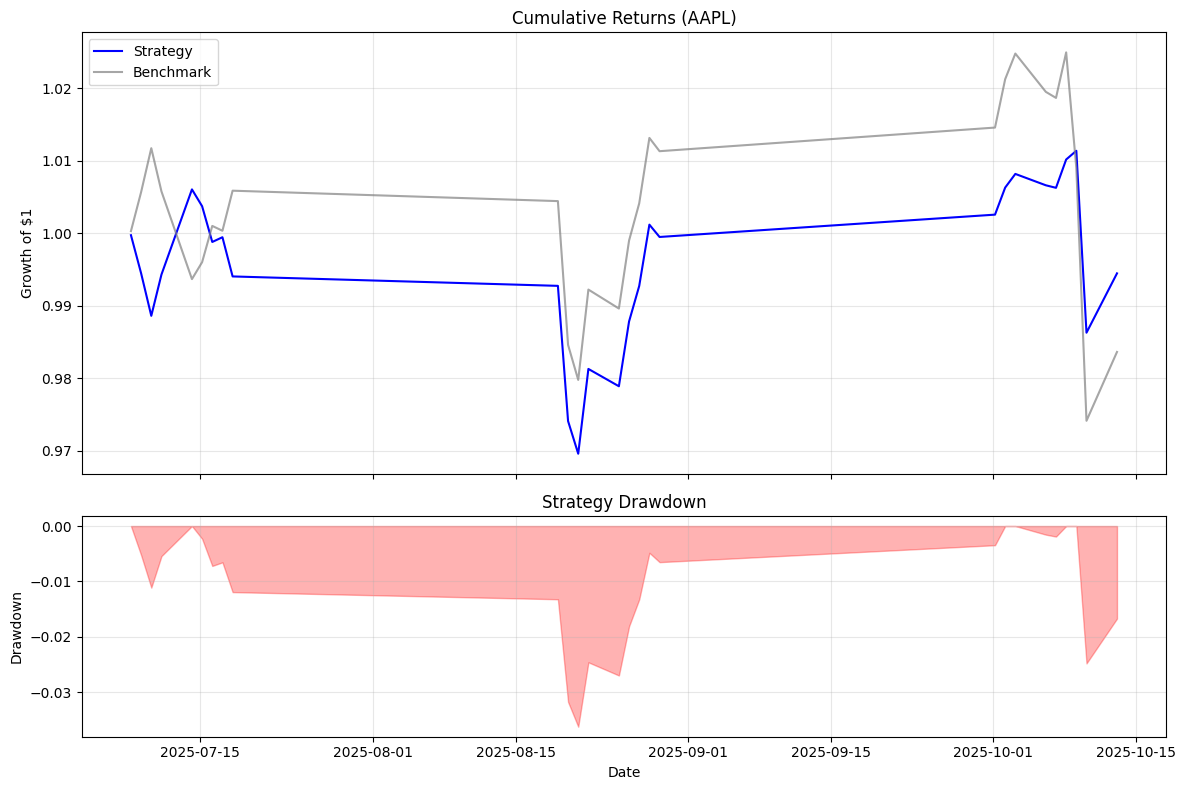

In [6]:
# Display Evaluation Metrics
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

if evaluation_results:
    df_results = pd.DataFrame(evaluation_results)
    
    # Metrics to summarize
    metrics_cols = ['Return', 'Benchmark Return', 'Win Rate', 'Sharpe', 'Sortino', 'Jensen Alpha']
    
    # 1. Calculate Summary Statistics
    # We use describe() to get count, mean, std, min, 25%, 50%, 75%, max
    summary_stats = df_results[metrics_cols].describe()
    
    # Formatting
    format_dict = {
        'Return': '{:.2%}',
        'Benchmark Return': '{:.2%}',
        'Win Rate': '{:.2%}',
        'Sharpe': '{:.2f}',
        'Sortino': '{:.2f}',
        'Jensen Alpha': '{:.4f}'
    }
    
    print(f"\n=== Performance Summary (Across {len(df_results)} Windows) ===")
    display(summary_stats.style.format(format_dict))
    
    # 2. Ticker-wise Aggregated Stats (Treating all windows as one continuous run)
    print("\n=== Ticker-wise Aggregated Stats ===")
    
    # Calculate and print testing period
    min_w = df_results['Window'].min()
    max_w = df_results['Window'].max()
    
    # Find window definitions
    start_window = next((w for w in windows if w['window_id'] == min_w), None)
    end_window = next((w for w in windows if w['window_id'] == max_w), None)
    
    if start_window and end_window:
        start_idx = start_window['test_range'][0]
        end_idx = end_window['test_range'][1] - 1
        
        # Attempt to get dates
        try:
            if isinstance(data.index, pd.DatetimeIndex):
                s_date = data.index[start_idx].strftime('%Y-%m-%d')
                e_date = data.index[end_idx].strftime('%Y-%m-%d')
            elif 'Date' in data.columns:
                s_date = pd.to_datetime(data.iloc[start_idx]['Date']).strftime('%Y-%m-%d')
                e_date = pd.to_datetime(data.iloc[end_idx]['Date']).strftime('%Y-%m-%d')
            else:
                s_date = str(data.index[start_idx])
                e_date = str(data.index[end_idx])
            
            print(f"Testing Period: {s_date} to {e_date}")
        except Exception as e:
            print(f"Testing Period Indices: {start_idx} to {end_idx}")

    # Group by Ticker and calculate mean of metrics
    ticker_stats = df_results.groupby('TICKER')[metrics_cols].mean()
    display(ticker_stats.style.format(format_dict))
    
    # 3. Plot Cumulative Returns and Drawdown
    if daily_returns_history:
        print("\n=== Cumulative Performance Plot ===")
        
        # Concatenate all windows
        all_strat_ret = []
        all_bench_ret = []
        all_dates = []
        
        for item in daily_returns_history:
            all_strat_ret.extend(item['strategy_returns'])
            all_bench_ret.extend(item['benchmark_returns'])
            all_dates.extend(item['dates'])
            
        # Create DataFrame for plotting
        df_plot = pd.DataFrame({
            'Strategy': all_strat_ret,
            'Benchmark': all_bench_ret
        }, index=all_dates)
        
        # Calculate Cumulative Returns
        df_cum = (1 + df_plot).cumprod()
        
        # Calculate Drawdown
        running_max = df_cum['Strategy'].cummax()
        drawdown = (df_cum['Strategy'] - running_max) / running_max
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
        
        # Ax1: Cumulative Returns
        ax1.plot(df_cum.index, df_cum['Strategy'], label='Strategy', color='blue')
        ax1.plot(df_cum.index, df_cum['Benchmark'], label='Benchmark', color='gray', alpha=0.7)
        ax1.set_title(f'Cumulative Returns ({ticker})')
        ax1.set_ylabel('Growth of $1')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Ax2: Drawdown
        ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3, label='Drawdown')
        ax2.set_title('Strategy Drawdown')
        ax2.set_ylabel('Drawdown')
        ax2.set_xlabel('Date')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
else:
    print("No evaluation results found. Make sure to run the training loop first.")